# Butterfly Image Classification with PyTorch

This notebook implements a complete image classification pipeline using PyTorch and EfficientNet for butterfly species recognition.

## Dataset Overview
- Training images with labels from CSV files
- Test images for prediction submission
- 75 different butterfly species to classify
- Uses transfer learning with pre-trained EfficientNet backbone

## Pipeline Steps
1. **Setup & Installation** - Install required packages and import libraries
2. **Configuration** - Set up paths, model parameters, and training hyperparameters
3. **Data Loading** - Create custom dataset class and data loaders with augmentation
4. **Model Definition** - Build EfficientNet-based classifier with custom head
5. **Training** - Train the model with validation tracking
6. **Evaluation** - Analyze model performance with metrics and visualizations
7. **Prediction** - Generate predictions for test set and create submission file

## 1. Setup & Installation

All required packages are to be installed and import the necessary libraries for the image classification pipeline.

In [ ]:
# Install required packages
!pip install torch torchvision timm pandas scikit-learn matplotlib seaborn tqdm Pillow

In [1]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import timm
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

c:\Users\aipc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# monitor GPU usage during training
import torch
import time

def check_gpu_usage():
    if torch.cuda.is_available():
        print(f"GPU Device: {torch.cuda.get_device_name()}")
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
        print(f"GPU Memory Cached: {torch.cuda.memory_reserved()/1024**3:.2f} GB")
        print(f"GPU Memory Total: {torch.cuda.get_device_properties(0).total_memory/1024**3:.2f} GB")
        
check_gpu_usage()

GPU Device: NVIDIA GeForce RTX 4070 Ti SUPER
GPU Memory Allocated: 0.00 GB
GPU Memory Cached: 0.00 GB
GPU Memory Total: 15.99 GB


## 2. Configuration

Set up all configuration parameters including data paths, model settings, and training hyperparameters. Adjust the data paths for the Kaggle dataset.

In [ ]:
%cd "D:\Projects\DataScience\Portfolio\Image-Classification\Workspace\Image-Classification" 


# Configuration class with all parameters
class Config:
    def __init__(self):
        #self.data_dir = Path('/kaggle/input/butterfly-image-classification')
        self.data_dir = Path('data')  # Use relative path for Windows
        self.train_dir = self.data_dir / 'train'
        self.test_dir = self.data_dir / 'test'
        self.train_csv = self.data_dir / 'Training_set.csv'
        self.test_csv = self.data_dir / 'Testing_set.csv'

        self.output_dir = Path('output')
        self.model_dir = self.output_dir / 'models'
        self.logs_dir = self.output_dir / 'logs'
        self.results_dir = self.output_dir / 'results'

        # Device configuration
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Model parameters
        self.model_name = 'efficientnet_b0'
        self.img_size = 224
        self.num_classes = 75
        self.pretrained = True
        
        # Training parameters
        self.batch_size = 128  # Increased for RTX 4070 Ti SUPER
        self.num_workers = 2   # Adjusted for Windows
        self.pin_memory = True # Added for faster GPU transfer
        self.num_epochs = 30
        self.learning_rate = 0.001
        self.val_split = 0.2

# Initialize configuration
config = Config()
print(f"Device: {config.device}")
print(f"Model: {config.model_name}")
print(f"Image size: {config.img_size}")
print(f"Batch size: {config.batch_size}")
# print training set and test set paths
print(f"Training set path: {config.train_dir}")
print(f"Testing set path: {config.test_dir}")

D:\Projects\DataScience\Portfolio\Image-Classification\Workspace\Image-Classification
Device: cuda
Model: efficientnet_b0
Image size: 224
Batch size: 128
Training set path: data\train
Testing set path: data\test


## 3. Data Loading & Preprocessing

Create a custom PyTorch Dataset class and implement data loading with proper preprocessing and augmentation techniques.

In [4]:
# Custom Dataset class for butterfly images
class ButterflyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df
        self.img_dir = Path(img_dir)
        self.transform = transform
        self.is_test = is_test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        filename = self.df.iloc[idx]['filename']
        img_path = self.img_dir / filename
        
        # Load image and convert to RGB
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
            
        # Return image and filename for test, or image and label for train/val
        if self.is_test:
            return image, filename
        else:
            label = self.df.iloc[idx]['label_encoded']
            return image, label

In [5]:
# Data loading and preprocessing function
def load_data():
    # Check if files exist and print paths for debugging
    print("Loading CSV files...")
    print(f"Looking for train CSV at: {config.train_csv}")
    print(f"Looking for test CSV at: {config.test_csv}")
    print(f"Train CSV exists: {config.train_csv.exists()}")
    print(f"Test CSV exists: {config.test_csv.exists()}")
    
    # Load CSV files
    if not config.train_csv.exists():
        raise FileNotFoundError(f"Training CSV not found at: {config.train_csv}")
    if not config.test_csv.exists():
        raise FileNotFoundError(f"Test CSV not found at: {config.test_csv}")
        
    train_df = pd.read_csv(config.train_csv)
    test_df = pd.read_csv(config.test_csv)
    
    # Encode labels for training
    label_encoder = LabelEncoder()
    train_df['label_encoded'] = label_encoder.fit_transform(train_df['label'])
    config.num_classes = len(label_encoder.classes_)
    
    # Split training data into train/validation sets
    train_data, val_data = train_test_split(
        train_df, test_size=config.val_split, 
        stratify=train_df['label_encoded'], random_state=42
    )
    
    # Define data transforms
    # Training transforms include augmentation
    train_transform = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Validation/test transforms without augmentation
    val_transform = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = ButterflyDataset(train_data, config.train_dir, train_transform)
    val_dataset = ButterflyDataset(val_data, config.train_dir, val_transform)
    test_dataset = ButterflyDataset(test_df, config.test_dir, val_transform, is_test=True)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0, pin_memory=True,
    persistent_workers=False)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True,
    persistent_workers=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True,
    persistent_workers=False)

    # Print dataset statistics
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Number of classes: {config.num_classes}")
    
    return train_loader, val_loader, test_loader, label_encoder

# Load all data
train_loader, val_loader, test_loader, label_encoder = load_data()

Loading CSV files...
Looking for train CSV at: data\Training_set.csv
Looking for test CSV at: data\Testing_set.csv
Train CSV exists: True
Test CSV exists: True
Training samples: 5199
Validation samples: 1300
Test samples: 2786
Number of classes: 75


## 4. Model Definition

Create the image classification model using EfficientNet as the backbone with a custom classifier head for butterfly species recognition.

In [6]:
# Image Classifier model using EfficientNet backbone
class ImageClassifier(nn.Module):
    def __init__(self, model_name='efficientnet_b0', num_classes=75, pretrained=True):
        super(ImageClassifier, self).__init__()
        
        # Load pre-trained EfficientNet model
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        
        # Get feature dimension and remove original classifier
        if hasattr(self.backbone, 'classifier'):
            feature_dim = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
        elif hasattr(self.backbone, 'head'):
            feature_dim = self.backbone.head.in_features
            self.backbone.head = nn.Identity()
        
        # Create custom classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        # Extract features from backbone
        features = self.backbone(x)
        # Pass through custom classifier
        return self.classifier(features)

# Create model instance
model = ImageClassifier(config.model_name, config.num_classes, config.pretrained)
model = model.to(config.device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

# Print model information
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model created with {total_params:,} total parameters")
print(f"Trainable parameters: {trainable_params:,}")

Model created with 4,701,895 total parameters
Trainable parameters: 4,701,895


## 5. Training Functions

Define the training and validation functions that will be used in the training loop.

In [7]:

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    avg_loss = running_loss / len(train_loader)
    
    return avg_loss, accuracy

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    avg_loss = running_loss / len(val_loader)
    
    return avg_loss, accuracy

## 6. Model Training

Execute the main training loop with validation tracking and best model saving.

In [ ]:
# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0

print("Starting training...")
for epoch in range(config.num_epochs):
    print(f"\nEpoch {epoch+1}/{config.num_epochs}")
    
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, config.device)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Print epoch results
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), config.model_dir / 'best_model.pth')
        print(f"New best model saved! Val Acc: {val_acc:.2f}%")

print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")

Starting training...

Epoch 1/30


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.28it/s]


Train Loss: 2.2024, Train Acc: 49.74%
Val Loss: 0.6108, Val Acc: 82.46%
New best model saved! Val Acc: 82.46%

Epoch 2/30


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]


Train Loss: 0.4348, Train Acc: 87.13%
Val Loss: 0.4834, Val Acc: 87.15%
New best model saved! Val Acc: 87.15%

Epoch 3/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]


Train Loss: 0.2452, Train Acc: 92.59%
Val Loss: 0.4146, Val Acc: 91.23%
New best model saved! Val Acc: 91.23%

Epoch 4/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]


Train Loss: 0.1499, Train Acc: 95.35%
Val Loss: 0.3846, Val Acc: 91.69%
New best model saved! Val Acc: 91.69%

Epoch 5/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.39it/s]


Train Loss: 0.1547, Train Acc: 95.56%
Val Loss: 0.3937, Val Acc: 91.38%

Epoch 6/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.29it/s]


Train Loss: 0.1426, Train Acc: 95.88%
Val Loss: 0.4230, Val Acc: 90.38%

Epoch 7/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]


Train Loss: 0.1230, Train Acc: 96.27%
Val Loss: 0.4805, Val Acc: 90.54%

Epoch 8/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.29it/s]


Train Loss: 0.0977, Train Acc: 97.25%
Val Loss: 0.4567, Val Acc: 91.62%

Epoch 9/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.38it/s]


Train Loss: 0.0990, Train Acc: 97.31%
Val Loss: 0.4579, Val Acc: 91.23%

Epoch 10/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.43it/s]


Train Loss: 0.0922, Train Acc: 97.19%
Val Loss: 0.4626, Val Acc: 90.69%

Epoch 11/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.37it/s]


Train Loss: 0.0722, Train Acc: 97.85%
Val Loss: 0.4950, Val Acc: 91.69%

Epoch 12/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]


Train Loss: 0.0670, Train Acc: 97.88%
Val Loss: 0.4301, Val Acc: 91.92%
New best model saved! Val Acc: 91.92%

Epoch 13/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]


Train Loss: 0.0702, Train Acc: 98.08%
Val Loss: 0.4971, Val Acc: 91.23%

Epoch 14/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]


Train Loss: 0.0642, Train Acc: 98.44%
Val Loss: 0.4799, Val Acc: 91.54%

Epoch 15/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]


Train Loss: 0.0784, Train Acc: 97.81%
Val Loss: 0.4623, Val Acc: 92.15%
New best model saved! Val Acc: 92.15%

Epoch 16/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s]


Train Loss: 0.0682, Train Acc: 98.44%
Val Loss: 0.4860, Val Acc: 91.31%

Epoch 17/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.90it/s]


Train Loss: 0.0601, Train Acc: 98.48%
Val Loss: 0.5938, Val Acc: 90.62%

Epoch 18/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]


Train Loss: 0.0820, Train Acc: 97.83%
Val Loss: 0.5098, Val Acc: 92.77%
New best model saved! Val Acc: 92.77%

Epoch 19/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s]


Train Loss: 0.0569, Train Acc: 98.40%
Val Loss: 0.5023, Val Acc: 92.54%

Epoch 20/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s]


Train Loss: 0.0627, Train Acc: 98.31%
Val Loss: 0.5609, Val Acc: 89.85%

Epoch 21/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.88it/s]


Train Loss: 0.0768, Train Acc: 98.12%
Val Loss: 0.5067, Val Acc: 92.15%

Epoch 22/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]


Train Loss: 0.0666, Train Acc: 98.35%
Val Loss: 0.4390, Val Acc: 92.38%

Epoch 23/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]


Train Loss: 0.0566, Train Acc: 98.35%
Val Loss: 0.4619, Val Acc: 92.31%

Epoch 24/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]


Train Loss: 0.0780, Train Acc: 98.04%
Val Loss: 0.4333, Val Acc: 92.08%

Epoch 25/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.00it/s]


Train Loss: 0.0665, Train Acc: 98.10%
Val Loss: 0.4630, Val Acc: 92.00%

Epoch 26/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s]


Train Loss: 0.0606, Train Acc: 98.44%
Val Loss: 0.4772, Val Acc: 91.54%

Epoch 27/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]


Train Loss: 0.0488, Train Acc: 98.79%
Val Loss: 0.4406, Val Acc: 92.92%
New best model saved! Val Acc: 92.92%

Epoch 28/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.89it/s]


Train Loss: 0.0463, Train Acc: 98.77%
Val Loss: 0.4365, Val Acc: 93.08%
New best model saved! Val Acc: 93.08%

Epoch 29/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.86it/s]


Train Loss: 0.0359, Train Acc: 98.88%
Val Loss: 0.3812, Val Acc: 93.38%
New best model saved! Val Acc: 93.38%

Epoch 30/30


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]

Train Loss: 0.0251, Train Acc: 99.29%
Val Loss: 0.4519, Val Acc: 93.23%

Training completed! Best validation accuracy: 93.38%


## 7. Training Visualization

Plot the training and validation curves to visualize the model's learning progress.

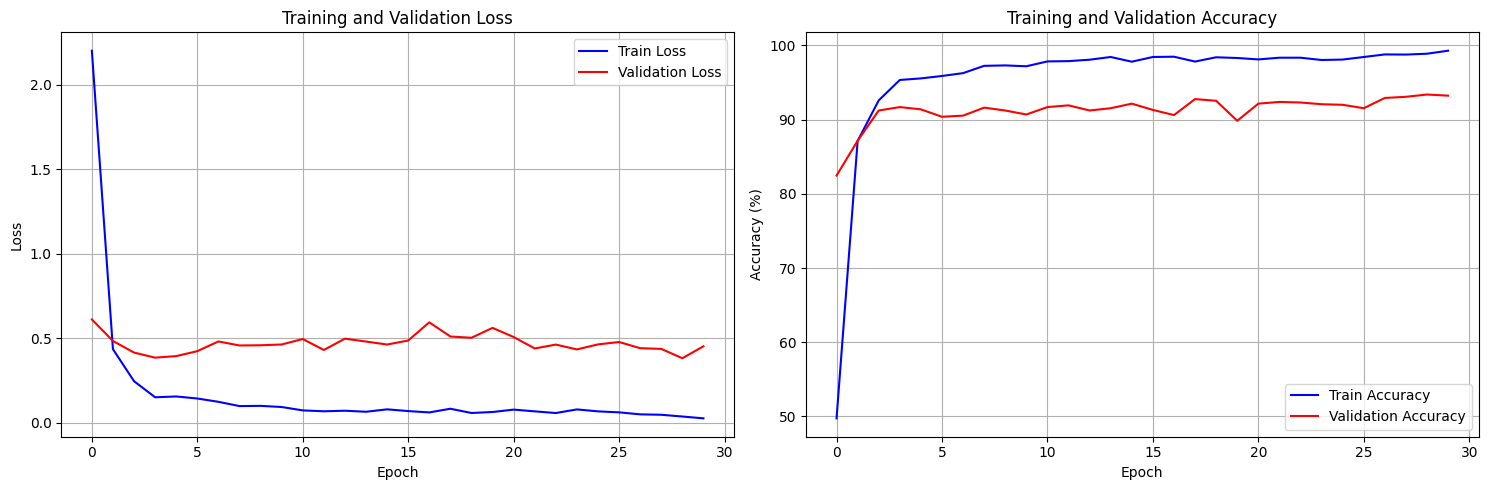

In [9]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 8. Model Evaluation

Load the best model and evaluate its performance on the validation set with detailed metrics.

In [10]:
# Load best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Function to get predictions
def get_predictions(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Getting predictions"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Get validation predictions
val_preds, val_labels = get_predictions(model, val_loader, config.device)

# Calculate final validation accuracy
final_val_acc = (val_preds == val_labels).mean() * 100
print(f"Final validation accuracy: {final_val_acc:.2f}%")

Getting predictions: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s]

Final validation accuracy: 93.38%


In [11]:
# Classification report
class_names = label_encoder.classes_
print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=class_names))

Classification Report:
                           precision    recall  f1-score   support

                   ADONIS       1.00      0.89      0.94        18
AFRICAN GIANT SWALLOWTAIL       1.00      0.93      0.97        15
           AMERICAN SNOOT       1.00      1.00      1.00        15
                    AN 88       1.00      1.00      1.00        17
                  APPOLLO       0.94      0.89      0.91        18
                    ATALA       1.00      0.95      0.97        20
 BANDED ORANGE HELICONIAN       1.00      0.90      0.95        20
           BANDED PEACOCK       1.00      1.00      1.00        17
            BECKERS WHITE       0.94      1.00      0.97        16
         BLACK HAIRSTREAK       1.00      0.71      0.83        17
              BLUE MORPHO       0.78      0.93      0.85        15
        BLUE SPOTTED CROW       0.94      1.00      0.97        17
           BROWN SIPROETA       0.95      0.95      0.95        20
            CABBAGE WHITE       0.90  

## 9. Confusion Matrix

Visualize the model's performance across all butterfly species with a confusion matrix.

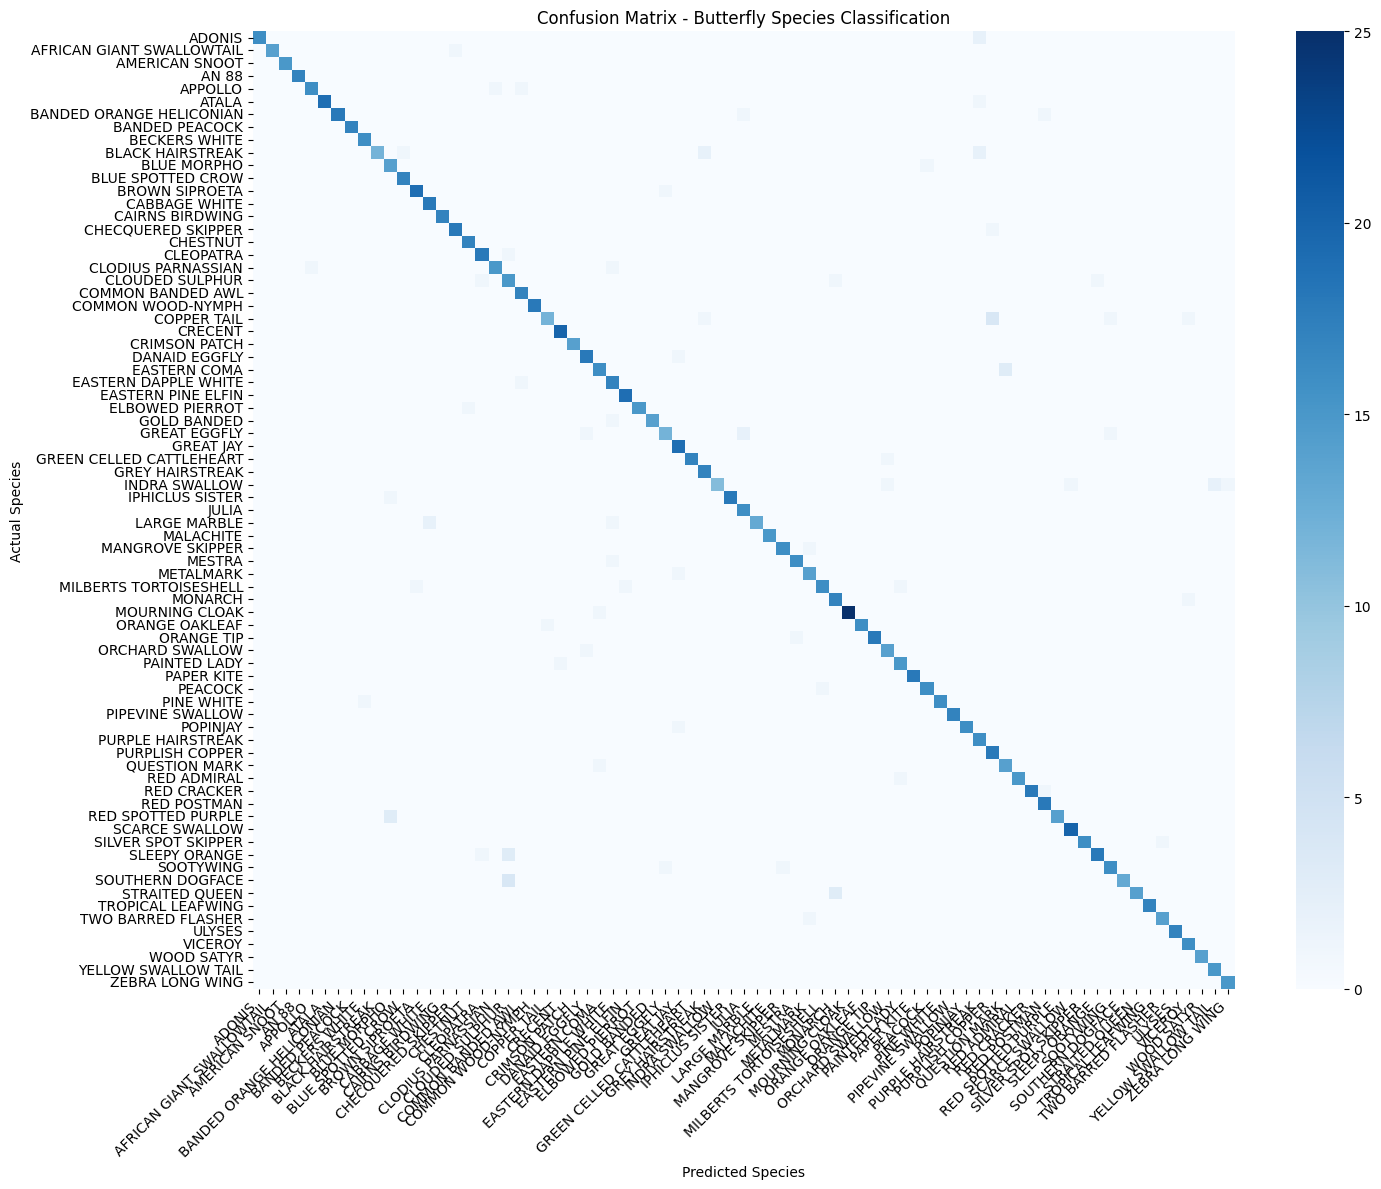

In [12]:
# Confusion matrix visualization
plt.figure(figsize=(15, 12))
cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Butterfly Species Classification')
plt.xlabel('Predicted Species')
plt.ylabel('Actual Species')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 10. Test Set Predictions

Generate predictions for the test set and create a submission file for Kaggle.

In [ ]:
# Generate test predictions
def predict_test_set(model, test_loader, device, label_encoder):
    model.eval()
    predictions = []
    filenames = []
    
    with torch.no_grad():
        for images, batch_filenames in tqdm(test_loader, desc="Predicting test set"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            # Convert predictions back to class names
            pred_classes = label_encoder.inverse_transform(predicted.cpu().numpy())
            
            predictions.extend(pred_classes)
            filenames.extend(batch_filenames)
    
    return filenames, predictions

# Get test predictions
test_filenames, test_predictions = predict_test_set(model, test_loader, config.device, label_encoder)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'filename': test_filenames,
    'label': test_predictions
})

# Save predictions
submission_df.to_csv(config.model_dir / 'submission.csv', index=False)
# print submission file path
print(f"Test predictions saved to {config.model_dir / 'submission.csv'}")
print(f"Total test predictions: {len(submission_df)}")
print("\nSample predictions:")
print(submission_df.head(10))

Predicting test set: 100%|██████████| 22/22 [00:06<00:00,  3.29it/s]

Test predictions saved to submission.csv
Total test predictions: 2786

Sample predictions:
         filename               label
0     Image_1.jpg          PINE WHITE
1    Image_10.jpg     ZEBRA LONG WING
2   Image_100.jpg       QUESTION MARK
3  Image_1000.jpg               JULIA
4  Image_1001.jpg         BLUE MORPHO
5  Image_1002.jpg       INDRA SWALLOW
6  Image_1003.jpg      STRAITED QUEEN
7  Image_1004.jpg      MOURNING CLOAK
8  Image_1005.jpg  CHECQUERED SKIPPER
9  Image_1006.jpg     GREY HAIRSTREAK


## 11. Prediction Analysis

Analyze the distribution of predictions across butterfly species.

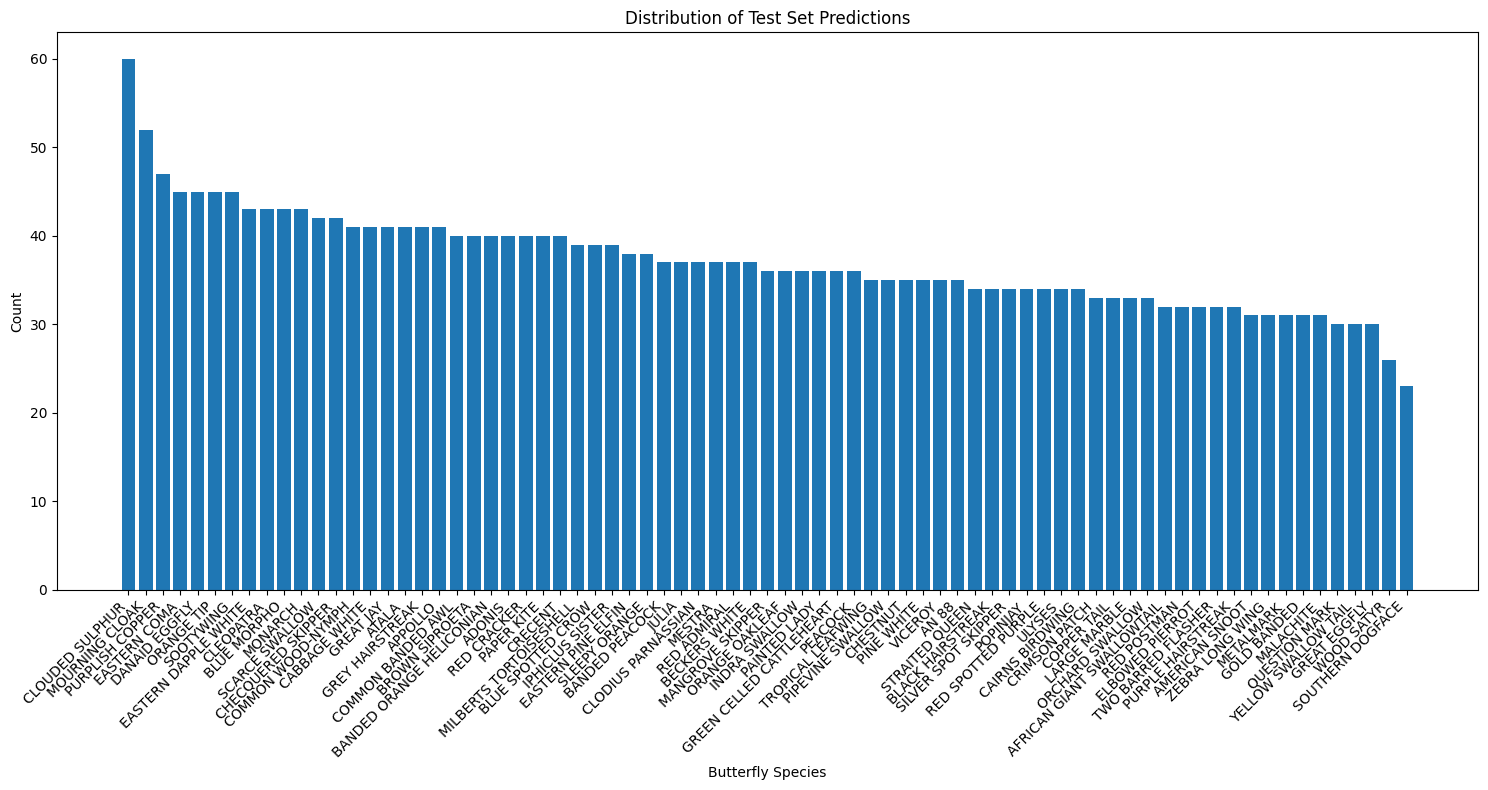

Predicted 75 different species out of 75 total classes


In [14]:
# Display prediction distribution
plt.figure(figsize=(15, 8))
pred_counts = submission_df['label'].value_counts()
plt.bar(range(len(pred_counts)), pred_counts.values)
plt.title('Distribution of Test Set Predictions')
plt.xlabel('Butterfly Species')
plt.ylabel('Count')
plt.xticks(range(len(pred_counts)), pred_counts.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Predicted {len(pred_counts)} different species out of {config.num_classes} total classes")

## Summary

This notebook implements a complete butterfly classification pipeline:

### Key Components:
1. **Data Loading**: Loaded training and test datasets with proper preprocessing and augmentation
2. **Model Architecture**: Used EfficientNet-B0 with custom classifier head for transfer learning
3. **Training**: Trained for 30 epochs with validation tracking and best model saving
4. **Evaluation**: Comprehensive evaluation with accuracy metrics, classification report, and confusion matrix
5. **Predictions**: Generated predictions for test set and saved to submission.csv

### Model Performance:
- Uses transfer learning with pre-trained EfficientNet backbone
- Implements data augmentation for better generalization
- Tracks training progress with validation metrics
- Saves best model based on validation accuracy

### Files Generated:
- `best_model.pth`: Best model weights
- `submission.csv`: Test set predictions for Kaggle submission

The model is ready for Kaggle submission and can be further improved by:
- Experimenting with different EfficientNet variants (B1, B2, etc.)
- Adjusting hyperparameters (learning rate, batch size, epochs)
- Implementing advanced techniques like learning rate scheduling or ensemble methods